# Non linear model ($L_e(d), Bl(d), K_m(d)$)

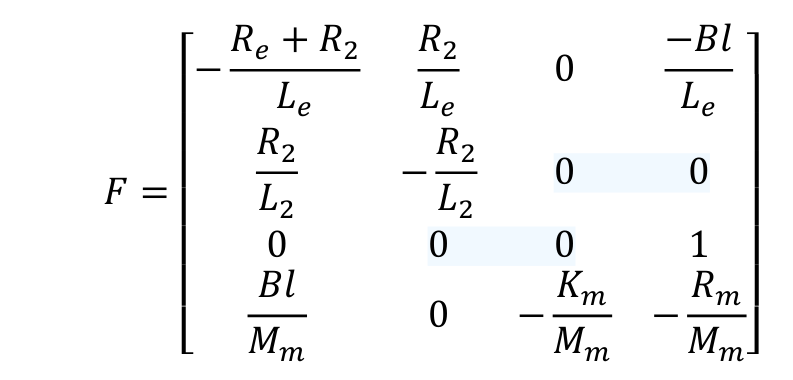

- valg af fs ud fra F?
- 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Minimum fs: 13027.62
fs: 65138
len samples: 325690
nperseg = 21712.666666666668
len seconds: 5.0
Num avg: 30.000921149594696
freq res: 3.0000921149594695


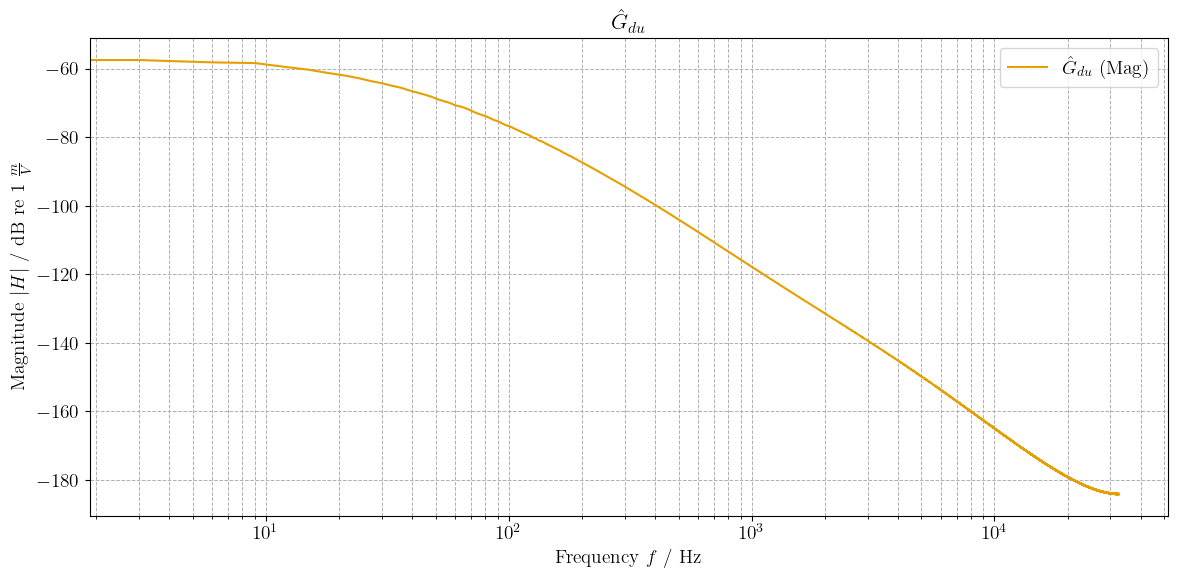

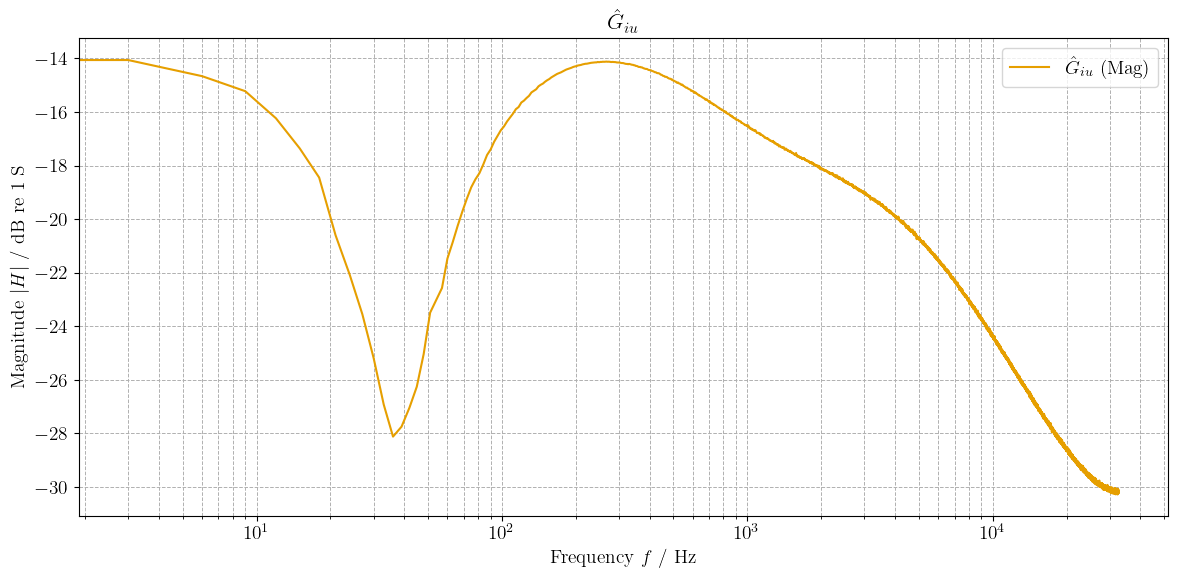

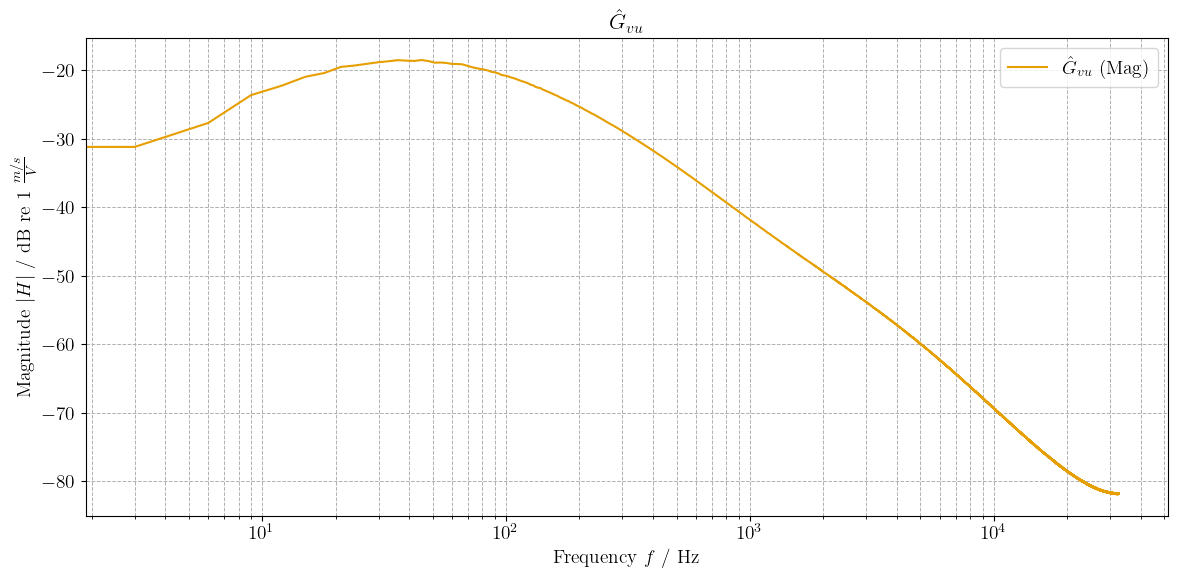

In [10]:
%load_ext autoreload
%autoreload 2
import util
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np 
import engutil


def solve_nonlinear_euler(u_signal, x0, fs, params, polys):
    """
    params = {
    'Re':  R_e,
    'Rm':  R_m,
    'Mm':  M_m,
    'R20': R_20,
    'L20': L_20

}

polys = {
    'Bl': poly_Bl,
    'K':  poly_K,
    'Le': poly_Le,
    'Li': poly_Li
}

where poly_Bl =poly_Bl = np.poly1d(Bln)

    """
    Ts = 1.0 / fs
    num_steps = len(u_signal)
    num_states = len(x0)
    
    # output:
    x_history = np.zeros((num_steps, num_states))
    x_curr = x0.copy()
    
    # static values
    Re = params['Re']
    R20 = params['R20']
    L20 = params['L20']
    Mm = params['Mm']
    Rm = params['Rm']
    
    # init matrices
    F = np.zeros((4, 4))
    G = np.zeros(4)
    
    # static parts of F
    
    F[2, 3] = 1.0
    F[3, 3] = -Rm / Mm
    
    for n in range(num_steps):
        x_history[n] = x_curr
        
        # i, i_L2, displacement, velocity
        i_curr = x_curr[0]
        disp   = x_curr[2] # grab displacement value
        
        # update polynomial values
        val_Bl = polys['Bl'](disp)
        val_K  = polys['K'](disp)
        val_Le = polys['Le'](disp)*polys["Li"](disp)
        val_R2 = R_20*val_Le/polys['Le'](0)
        val_L2 = L_20*val_Le/polys['Le'](0)

        # L_e = Ln*Li 
        # R_2 = R_20*L_e/L_e0
        # L_2 = L_20*L_e/L_e0

        # val_L2 = polys['Li'](disp)

        # val_Le = max(val_Le, 1e-6) 
        # val_L2 = max(val_Li, 1e-6)
        
        # # update F whereever it needs updating
        # F[0, 0] = -(Re + R20) / val_Le
        # F[0, 1] = R20 / val_Le
        # F[0, 3] = -val_Bl / val_Le
        
        # F[1, 0] = R20 / val_L2
        # F[1, 1] = -R20 / val_L2

        # F[3, 0] = val_Bl / Mm
        # F[3, 2] = -val_K / Mm


        F[0, 0] = -(Re + val_R2) / val_Le
        F[0, 1] = val_R2 / val_Le
        F[0, 3] = -val_Bl / val_Le
        
        F[1, 0] = val_R2 / val_L2
        F[1, 1] = -val_R2 / val_L2

        F[3, 0] = val_Bl / Mm
        F[3, 2] = -val_K / Mm



        G[0] = 1.0 / val_Le
        
        # do the Euler!
        dx = (F @ x_curr) + (G * u_signal[n])
        
        x_next = x_curr + (dx * Ts)
        x_curr = x_next
        
    return x_history


## Params from Python driven with 3Vrms pink noise
Bl=6.837193705842441
R_e=4.822146670305587
R_m=2.2833222074164836
K_m=1107.8705431240523
L_e0 =0.000305207582223968
M_m=0.020004906958875274
L_20=0.0004325286577462285
R_20=2.504536634680621

Bln=[
-2615563718.9455967,
-3023090.98130258,
-9835.616494456142,
21.171849188494026, 
Bl]

Kn=[
    1724760519892.831,
    -5658865945.33859,
    35715360.4027017,
    -210546.86882586573,
    K_m
] 
Ln=[
    20081.188591764963,
    -319.17779393260366,
    0.8155679039802962,
    -0.01018945289267653,
    L_e0
]
Li=[
    -0.0012237427320541485,
    -0.0014189369785025077,
    0.007354393550658496,
    0.005954177167801685,
    1
]
# L_e = Ln*Li 
# R_2 = R_20*L_e/L_e0
# L_2 = L_20*L_e/L_e0

    
# p = np.poly1d([1, 2, 3])
# coeffs from Bln is Bln[0] * x**4  Bln[1] * x**3 + Bln[2] * x**2 (...) + Bl
poly_Bl = np.poly1d(Bln)
poly_K  = np.poly1d(Kn)
poly_Le = np.poly1d(Ln) 
poly_Li = np.poly1d(Li)

F_linear_static = np.array([
    [-(R_e + R_20)/L_e,  R_20/L_e,    0.0,         -Bl/L_e],
    [R_20/L_20,          -R_20/L_20,    0.0,          0.0 ],
    [0.0,                   0.0,            0.0,          1.0],
    [Bl/M_m,                0.0,           -K_m/M_m,   -R_m/M_m ]
])

duration = 5

minimum_fs = util.calculate_min_fs(F_linear_static)
print(f"Minimum fs: {minimum_fs:.2f}")
fs = int(5*minimum_fs)
print(f"fs: {fs}")
# 1. create input signal
u = util.generate_pink_noise(fs*duration, fs, fmin=1)

# prepare data
params = {
    'Re':  R_e,
    'Rm':  R_m,
    'Mm':  M_m,
    'R20': R_20,
    'L20': L_20
}

polys = {
    'Bl': poly_Bl,
    'K':  poly_K,
    'Le': poly_Le,
    'Li': poly_Li
}

x0 = np.array([0,0,0,0]) # initial conditions
x = solve_nonlinear_euler(u, x0, fs, params, polys)
X = np.array([x[:,0], x[:,2], x[:,3]])

G_iu, G_du, G_vu, f = util.welchie(u, X, fs)

G_iu_mag_db, G_iu_phase, G_iu_mag_lin  = engutil.tf_to_magphase(G_iu)
G_du_mag_db, G_du_phase, G_du_mag_lin  = engutil.tf_to_magphase(G_du)
G_vu_mag_db, G_vu_phase, G_vu_mag_lin  = engutil.tf_to_magphase(G_vu)

engutil.plot_bode(f, [(G_du_mag_db, None)], legends=["$\\hat{G}_{du}$"], title="$\\hat{G}_{du}$", ylabel_left="Magnitude $\\left| H \\right|$ / dB re 1 $\\frac{m}{V}$")
engutil.plot_bode(f, [(G_iu_mag_db, None)], legends=["$\\hat{G}_{iu}$"], title="$\\hat{G}_{iu}$", ylabel_left="Magnitude $\\left| H \\right|$ / dB re 1 S")
engutil.plot_bode(f, [(G_vu_mag_db, None)], legends=["$\\hat{G}_{vu}$"], title="$\\hat{G}_{vu}$", ylabel_left="Magnitude $\\left| H \\right|$ / dB re 1 $\\frac{m/s}{V}$")


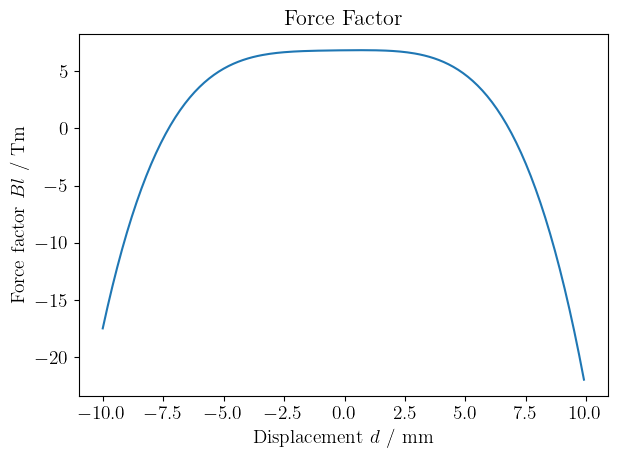

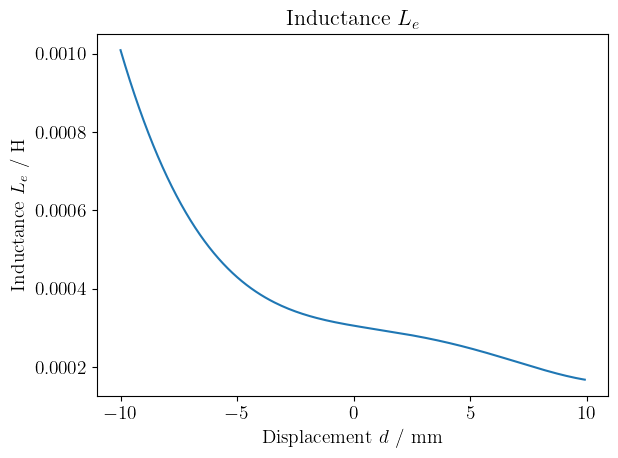

In [31]:
x = np.arange(-10e-3, 10e-3, 1e-4)
y = poly_Bl(x)
engutil.plot_time_series([(x*1e3,y)], ylabel="Force factor $Bl$ / Tm", xlabel="Displacement $d$ / mm", title="Force Factor")

x = np.arange(-10e-3, 10e-3, 1e-4)
y = poly_Le(x)
engutil.plot_time_series([(x*1e3,y)], ylabel="Inductance $L_e$ / H", xlabel="Displacement $d$ / mm", title="Inductance $L_e$")



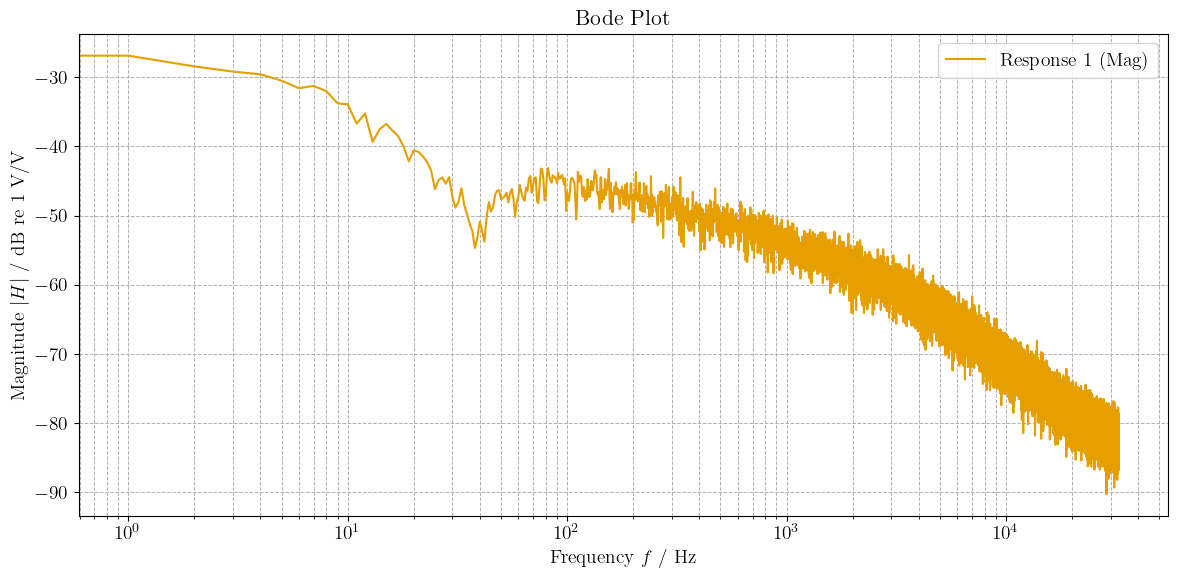

In [23]:
# ([x[:,0], x[:,2], x[:,3]
f, S = util.magnitude_spectrum(x[:,0], fs, window="hann", window_length=fs)    

engutil.plot_bode(f, [(20*np.log10(np.abs(S)), None)])

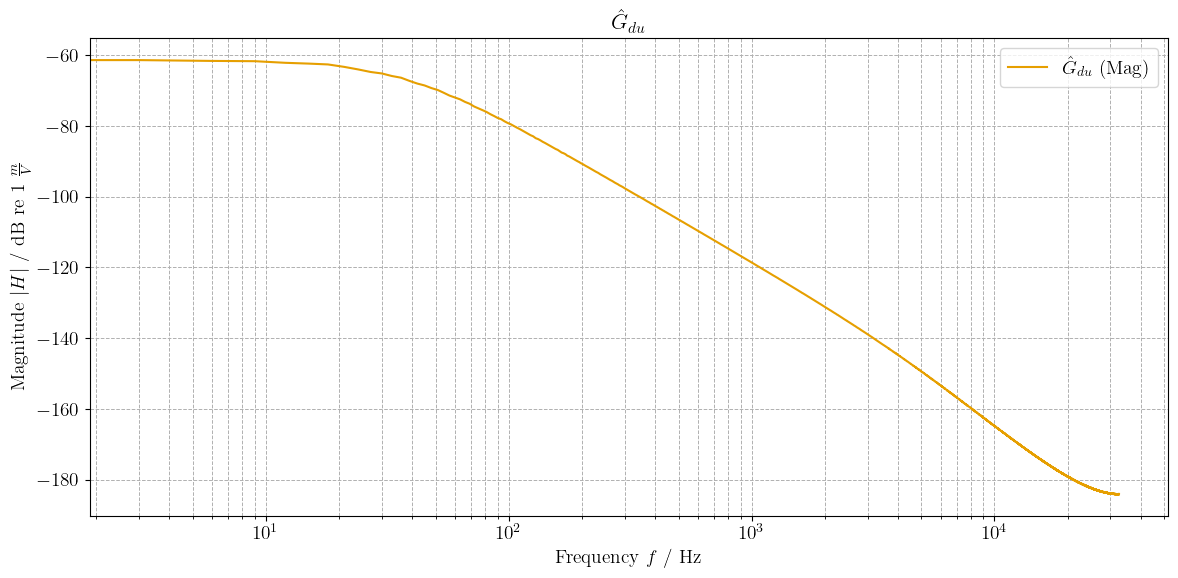

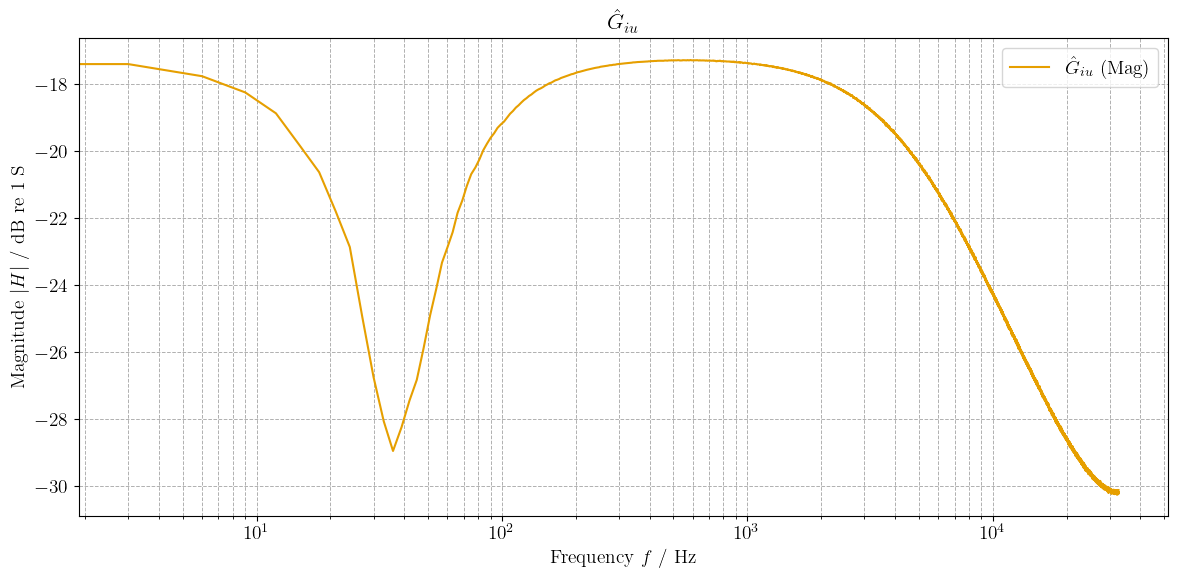

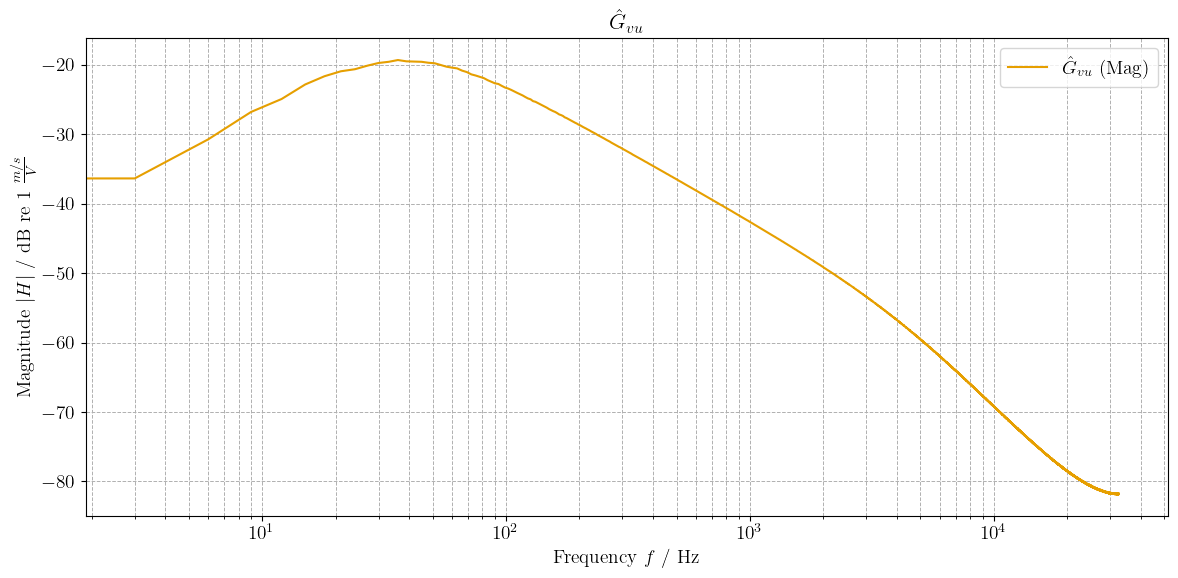

In [13]:

G_iu_mag_db, G_iu_phase, G_iu_mag_lin  = engutil.tf_to_magphase(G_iu)
G_du_mag_db, G_du_phase, G_du_mag_lin  = engutil.tf_to_magphase(G_du)
G_vu_mag_db, G_vu_phase, G_vu_mag_lin  = engutil.tf_to_magphase(G_vu)

engutil.plot_bode(f, [(G_du_mag_db, None)], legends=["$\\hat{G}_{du}$"], title="$\\hat{G}_{du}$", ylabel_left="Magnitude $\\left| H \\right|$ / dB re 1 $\\frac{m}{V}$")
engutil.plot_bode(f, [(G_iu_mag_db, None)], legends=["$\\hat{G}_{iu}$"], title="$\\hat{G}_{iu}$", ylabel_left="Magnitude $\\left| H \\right|$ / dB re 1 S")
engutil.plot_bode(f, [(G_vu_mag_db, None)], legends=["$\\hat{G}_{vu}$"], title="$\\hat{G}_{vu}$", ylabel_left="Magnitude $\\left| H \\right|$ / dB re 1 $\\frac{m/s}{V}$")


Minimum fs: 13027.62
len samples: 325690
nperseg = 21712.666666666668
len seconds: 5.0
Num avg: 30.000921149594696
freq res: 3.0000921149594695


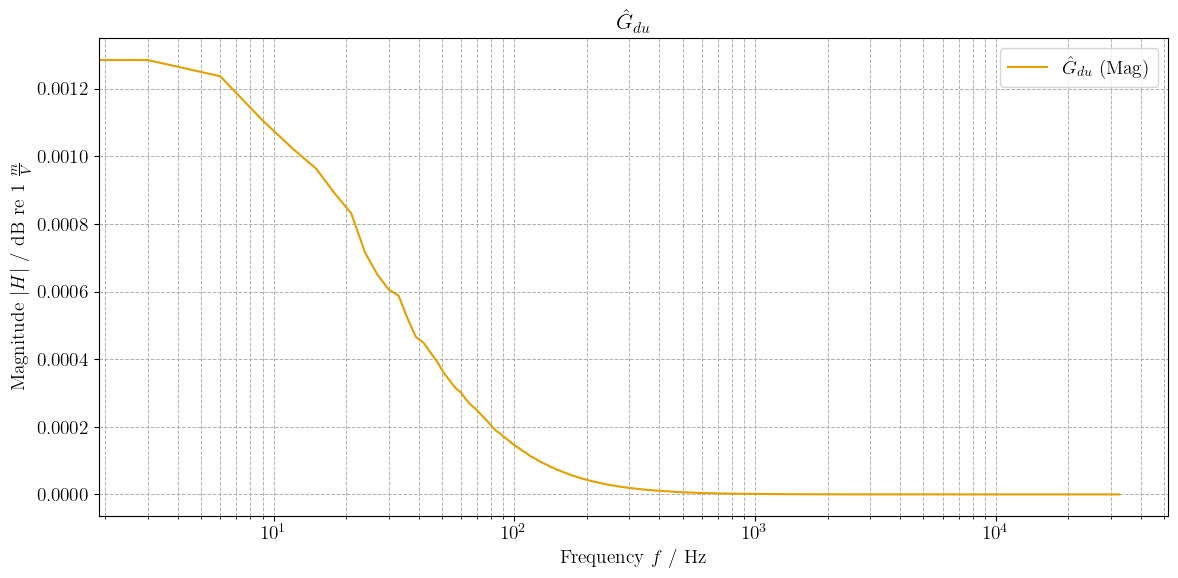

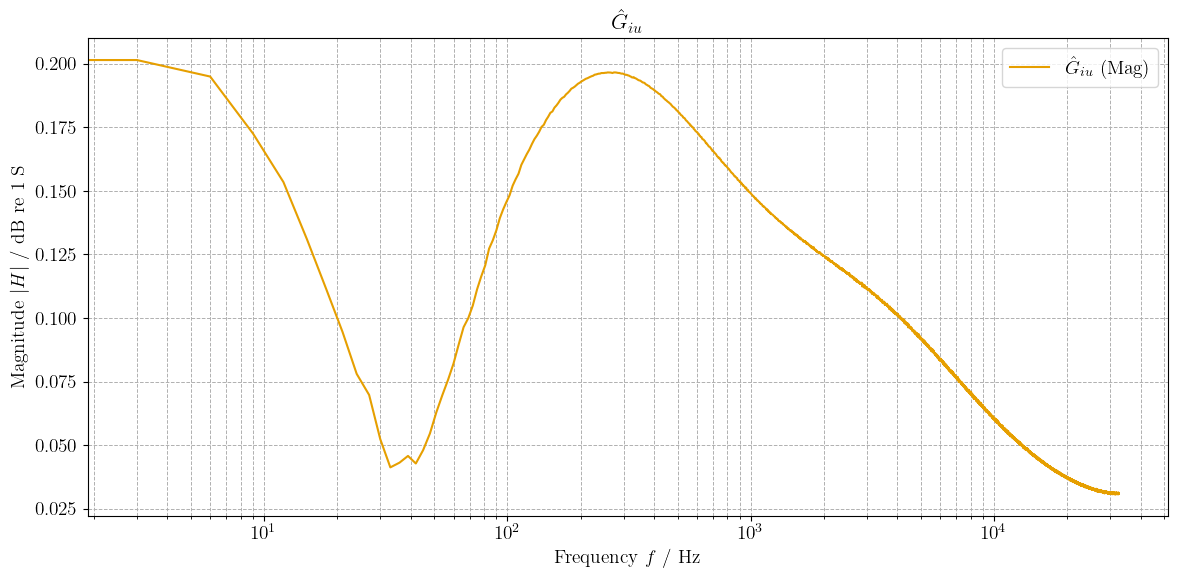

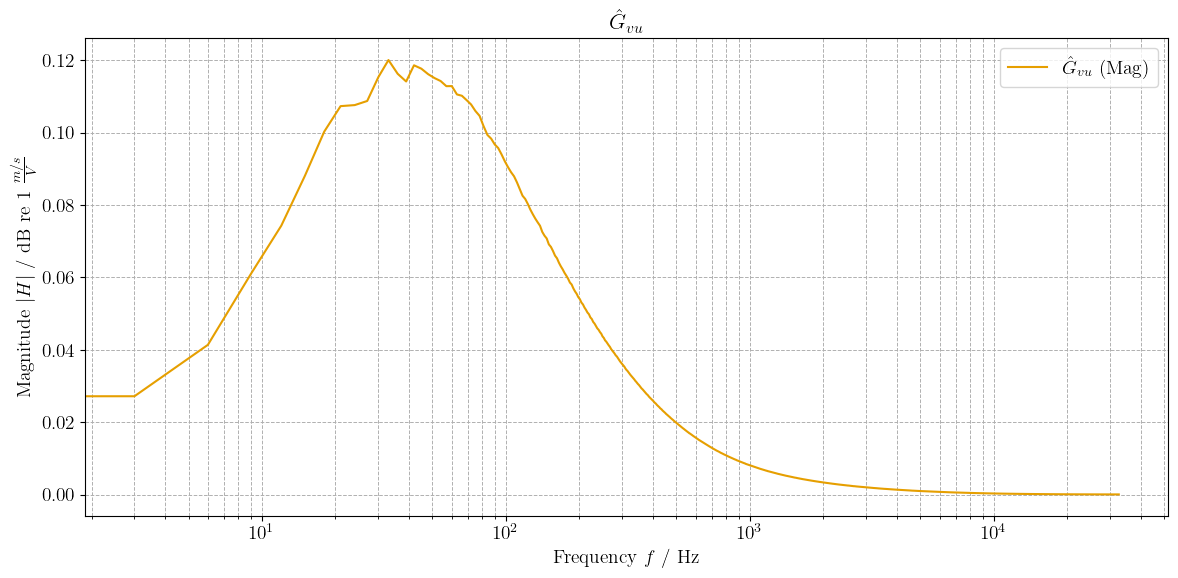

In [ ]:

F = np.array([
    [-(R_e + R_20)/L_e,  R_20/L_e,    0.0,     -Bl/L_e],
    [R_20/L_20, -R_20/L_20, 0.0,         0.0 ],
    [0.0, 0.0, 0.0, 1.0],
    [Bl/M_m,   0.0, -K_m/M_m,   -R_m/M_m ]
])

G = np.array([
    1.0/L_e,
    0.0,
    0.0,
    0.0
])

x0 = np.array([
    0.0,
    0.0,
    0.0,
    0.0
])

